In [93]:
%load_ext autoreload
%autoreload 2

import numpy as np
import mne
import moabb
import ordpy
from ordpy import maximum_complexity_entropy, minimum_complexity_entropy
from moabb.datasets import BNCI2014_001
from moabb.paradigms import MotorImagery
from mne_connectivity import spectral_connectivity_epochs
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib import colormaps
from tqdm import tqdm
import nolds
import warnings
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
def symmetrize(A):
	return A + A.T - np.diag(np.diag(A))

In [95]:
# From https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8865144/ Table 2 Cortex Means
ch_names = [
    "Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "C5", "C3", "C1", "Cz", "C2",
        "C4", "C6", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz",
        "EOG1", "EOG2", "EOG3"
]

EEG_Locations = {
	"Fz": [0.88, 34.43, 62.21],
	"FC3": [-46.09, 7.35, 56.46],
	"FC1": [-24.69, 5.73, 71.11],
	"FCz": [0.41, 6.77, 75.19],
	"FC2": [24.09, 5.4, 72.18],
	"FC4": [47.52, 6.49, 58.34],
	"C5": [-66.15, -20.58, 33.83],
	"C3": [-50.88, -21.18, 59.95],
	"C1": [-25.56, -23.82, 75.26],
	"Cz": [-0.47, -24.64, 80.16],
	"C2": [23.84, -24.31, 78.00],
	"C4": [50.78, -23.18, 63.58],
	"C6": [66.48, -21.77, 36.16],
	"CP3": [-49.15, -47.78, 58.42],
	"CP1": [-25.64, -48.14, 71.46],
	"CPz": [-0.73, -50.47, 75.85],
	"CP2": [24.46, -49.71, 75.38],
	"CP4": [46.66, -48.71, 62.98],
	"P1":  [-25.9, -68.45, 61.21],
	"Pz": [-1.94, -69.12, 66.04],
	"P2": [20.8, -69.28, 64.82],
	"POz": [-2.76, -90.20, 42.12]
}

In [96]:
paradigm = MotorImagery(n_classes=4)
mne.set_config("MNE_DATA", "/home/hice1/mchen439/scratch/mne_data")
mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")
print(mne.get_config())

Choosing from all possible events


{'MNE_DATA': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_ALEXEEG_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_BNCI_PATH': '/home/hice1/mchen439/scratch/mne_data', 'MNE_DATASETS_EEGBCI_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_FAKEDATASET-IMAGERY-10-2--60-60--120-120--FAKE1-FAKE2-FAKE3--C3-CZ-C4_PATH': '/tmp/tmpwour6ucf', 'MNE_DATASETS_FAKEVIRTUALREALITYDATASET-P300-21-1--60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60-60--120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120-120--TARGET-NONTARGET--C3-CZ-C4_PATH': '/tmp/tmpvhx98uwa', 'MNE_DATASETS_GIGADB_PATH': '/home/hice1/mchen439/mne_data', 'MNE_DATASETS_LEE2019-MI_PATH': '/home/hice1/mchen439/mne

/scratch/602589/ipykernel_188758/3997935127.py:3: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_BNCI_PATH"
  mne.set_config("MNE_DATASETS_BNCI_PATH", "/home/hice1/mchen439/scratch/mne_data")


In [97]:
datasetMotorImagery = BNCI2014_001()
subjects = [1]
with warnings.catch_warnings(action="ignore"):
	X, y, metadata = paradigm.get_data(dataset=datasetMotorImagery, subjects=subjects)
print(metadata.columns)
print(np.unique(y))

Index(['subject', 'session', 'run'], dtype='object')
['feet' 'left_hand' 'right_hand' 'tongue']


In [98]:
print(X.shape, y.shape, type(X), type(y), print(metadata.shape), print(type(metadata)))

(576, 3)
<class 'pandas.core.frame.DataFrame'>
(576, 22, 1001) (576,) <class 'numpy.ndarray'> <class 'numpy.ndarray'> None None


In [99]:
#print(X[0, 0, :])
#low_sos = scipy.signal.butter(3, 32, 'low', output='sos', fs=250)
#high_sos = scipy.signal.butter(3, 8, 'high', output='sos', fs=250)
#filtered = scipy.signal.sosfilt(high_sos, scipy.signal.sosfilt(low_sos, X[0, 0, :]))
#print(filtered)

In [100]:
#X_filtered = np.zeros(X.shape)

#for i in tqdm(range(X.shape[0])):
#    for j in range(X.shape[1]):
#        X_filtered[i, j] = scipy.signal.sosfilt(high_sos, scipy.signal.sosfilt(low_sos, X[i, j, :]))
#X = X_filtered

In [101]:
#print((X - X_filtered).sum())

In [102]:
print(metadata.head())

   subject session run
0        1  0train   0
1        1  0train   0
2        1  0train   0
3        1  0train   0
4        1  0train   0


In [103]:
y_encoded = np.zeros(y.shape)
for idx in range(y.shape[0]):
	if y[idx] == "tongue":
		y_encoded[idx] = 0
	elif y[idx] == "right_hand":
		y_encoded[idx] = 1
	elif y[idx] == "left_hand":
		y_encoded[idx] = 2
	else:
		y_encoded[idx] = 3

In [104]:
colors = ['#C05A3C', '#3888BA']

In [105]:
labels_3, trial_1_dx_3 = ordpy.ordinal_distribution(data=X[0, :, 0:100], dx=int(3), taux=3)
labels_3_str = []
for symbol in range(labels_3.shape[0]):
	labels_3_str.append(''.join(str(x) for x in labels_3[symbol]))

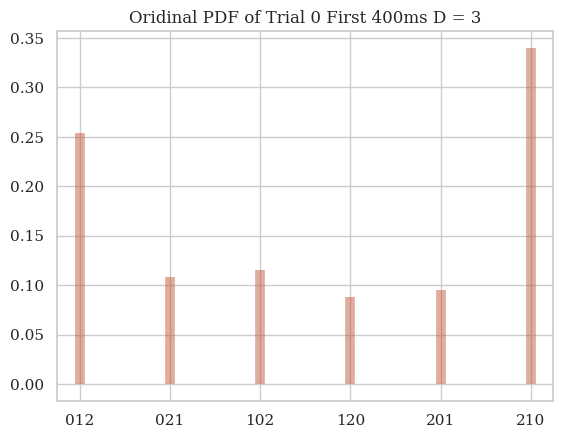

In [106]:
fig, ax = plt.subplots()
ax.vlines([i for i in range(len(labels_3_str))],
             ymin=0,
             ymax=trial_1_dx_3,
             color=colors[0],
             linewidth=7,
             alpha=.5)
ax.set_xticks(ticks=[i for i in range(len(labels_3_str))], labels=labels_3_str)
plt.title("Oridinal PDF of Trial 0 First 400ms D = 3")
plt.show()

In [107]:
labels_5, trial_1_dx_5 = ordpy.ordinal_distribution(data=X[0, :, 0:100], dx=int(5), taux=3)
labels_5_str = []
for symbol in range(labels_5.shape[0]):
	labels_5_str.append(''.join(str(x) for x in labels_5[symbol]))

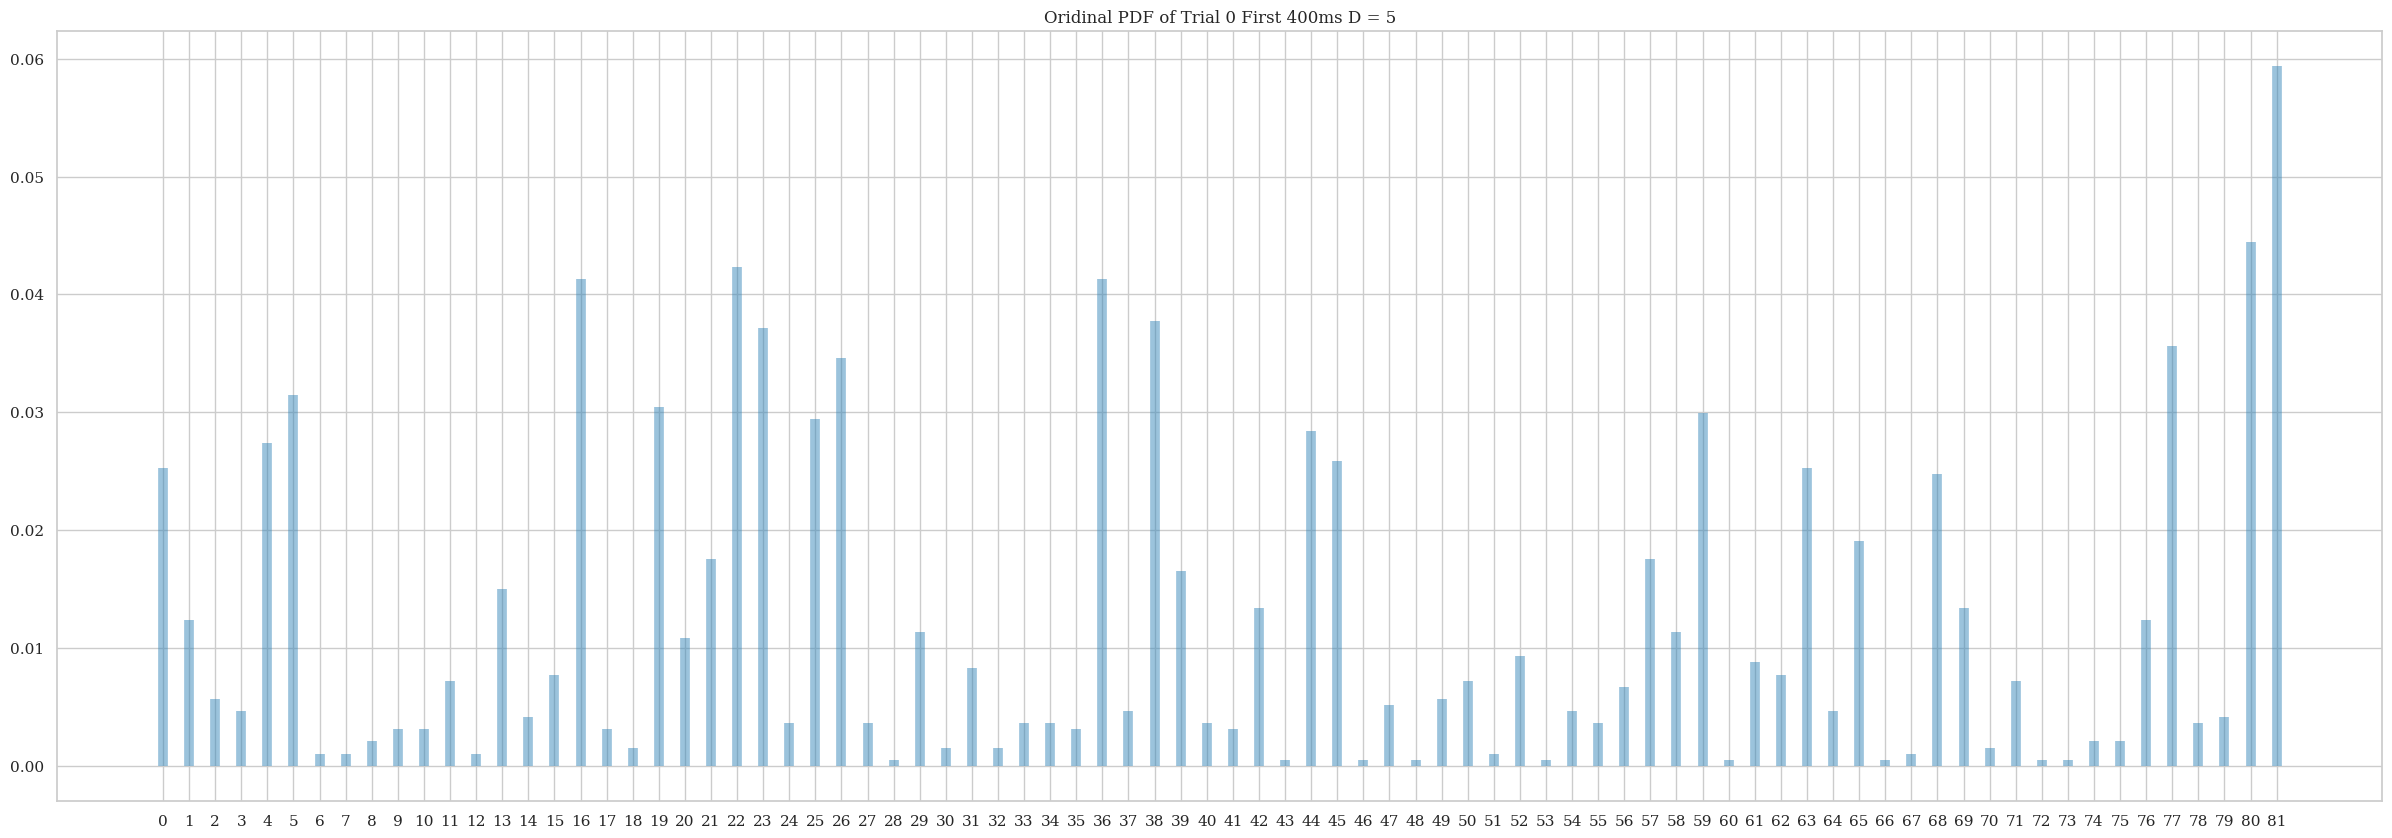

In [108]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.vlines([i for i in range(len(labels_5_str))],
             ymin=0,
             ymax=trial_1_dx_5,
             color=colors[1],
             linewidth=7,
             alpha=.5)
ax.set_xticks(ticks=[i for i in range(len(labels_5_str))])
plt.title("Oridinal PDF of Trial 0 First 400ms D = 5")
plt.show()

In [109]:
with open('lyap_r_250.npy', 'wb+') as f:
	np.save(f, lyap_r_250)

NameError: name 'lyap_r_250' is not defined

In [110]:
with open('lyap_r_1000.npy', 'wb+') as f:
	np.save(f, lyap_r_1000)

NameError: name 'lyap_r_1000' is not defined

In [130]:
def generate_complexity_entropy_values_whole_brain(X, y_encoded, index_start, index_end):
	assert X.shape[0] == y_encoded.shape[0]
	entropy_complexities = np.zeros((X.shape[0], 3)) # entropy, complexity, and label for trial
	for i in tqdm(range(X.shape[0])):
		entropy, complexity = ordpy.complexity_entropy(data=X[i, :,index_start:index_end], dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
		entropy_complexities[i][0] = entropy
		entropy_complexities[i][1] = complexity
		entropy_complexities[i][2] = y_encoded[i]
	return entropy_complexities

In [133]:
hc_min_curve = minimum_complexity_entropy(dx=5, dy=1, size=200).T
hc_max_curve = maximum_complexity_entropy(dx=5, dy=1, m=10).T
#hc_max_curve = maximum_complexity_entropy(dx=6).T
#hc_min_curve = minimum_complexity_entropy(dx=6, size=719).T

print(hc_min_curve.shape, hc_max_curve.shape)
hmin, cmin = hc_min_curve  
hmax, cmax = hc_max_curve  

(2, 200) (2, 1190)


100%|██████████████████████████████████████████████████████████| 576/576 [00:12<00:00, 45.10it/s]
/scratch/602589/ipykernel_188758/1208215417.py:20: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax[idx].legend((upper, lower, tongue_points, right_hand_points, left_hand_points, feet_points), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Tongue", "Right Hand", "Left Hand", "Feet"), scatterpoints=1)
100%|██████████████████████████████████████████████████████████| 576/576 [00:26<00:00, 21.60it/s]


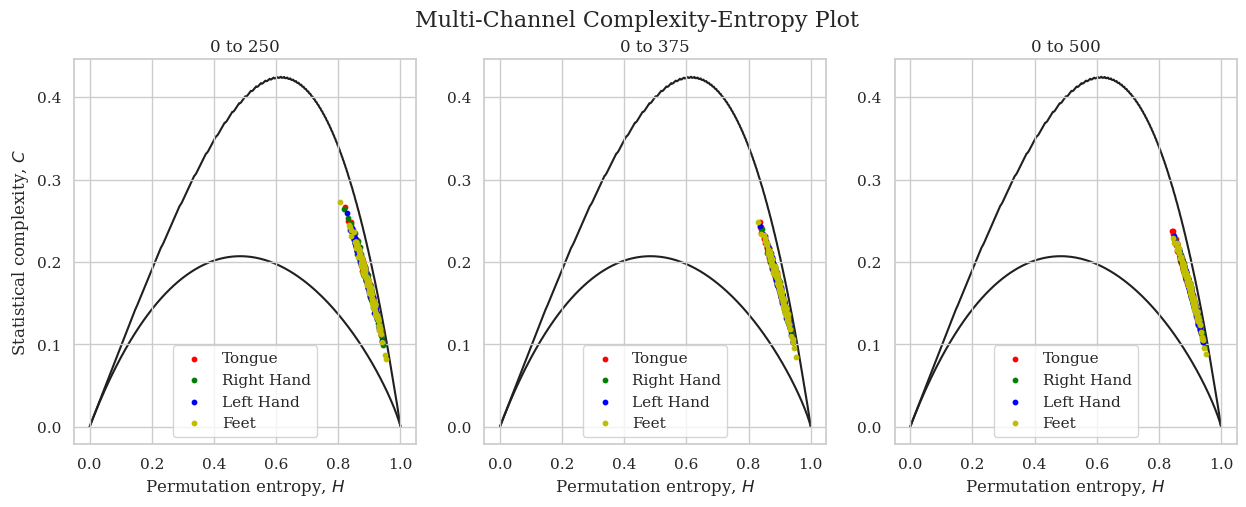

In [134]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_ylabel('Statistical complexity, $C$')
f.suptitle('Multi-Channel Complexity-Entropy Plot', fontsize=16)
for idx, (start_idx, end_idx) in enumerate([(0, 250), (0, 375), (0, 500)]):
	result_all_trials = generate_complexity_entropy_values_whole_brain(X, y_encoded, start_idx, end_idx)
	tongue = result_all_trials[result_all_trials[:, 2] == 0]
	right_hand = result_all_trials[result_all_trials[:, 2] == 1]
	left_hand = result_all_trials[result_all_trials[:, 2] == 2]
	feet = result_all_trials[result_all_trials[:, 2] == 3]
	upper = ax[idx].plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)
	lower = ax[idx].plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)
	tongue_points = ax[idx].scatter(x=tongue[:,0], y=tongue[:,1], c="r", s=10)
	right_hand_points = ax[idx].scatter(x=right_hand[:,0], y=right_hand[:,1], c="g", s=10)
	left_hand_points = ax[idx].scatter(x=left_hand[:,0], y=left_hand[:,1], c="b", s=10)
	feet_points = ax[idx].scatter(x=feet[:,0], y=feet[:,1], c="y", s=10)
	ax[idx].set_xlabel('Permutation entropy, $H$')
	#ax[0, idx].set_ylabel('Statistical complexity, $C$')
	ax[idx].set_title(f'{start_idx} to {end_idx}')
	ax[idx].grid(visible=True)
	ax[idx].legend((upper, lower, tongue_points, right_hand_points, left_hand_points, feet_points), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Tongue", "Right Hand", "Left Hand", "Feet"), scatterpoints=1)
plt.show()

In [22]:
def generate_complexity_entropy_values_channel(X, y_encoded, channel):
	assert X.shape[0] == y_encoded.shape[0]
	entropy_complexities = np.zeros((X.shape[0], 3)) # entropy, complexity, and label for trial
	for i in tqdm(range(X.shape[0])):
		entropy, complexity = ordpy.complexity_entropy(data=X[i, channel, :250], dx=int(4), dy=int(1), taux=int(3), tauy=int(1))
		entropy_complexities[i][0] = entropy
		entropy_complexities[i][1] = complexity
		entropy_complexities[i][2] = y_encoded[i]
	return entropy_complexities

100%|█████████████████████████████████████████████████████████| 576/576 [00:00<00:00, 875.33it/s]
/scratch/602589/ipykernel_188758/3341807713.py:23: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax[row_idx, col_idx].legend((upper, lower, tongue_points, right_hand_points, left_hand_points, feet_points), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Tongue", "Right Hand", "Left Hand", "Feet"), scatterpoints=1)
100%|█████████████████████████████████████████████████████████| 576/576 [00:00<00:00, 864.56it/s]


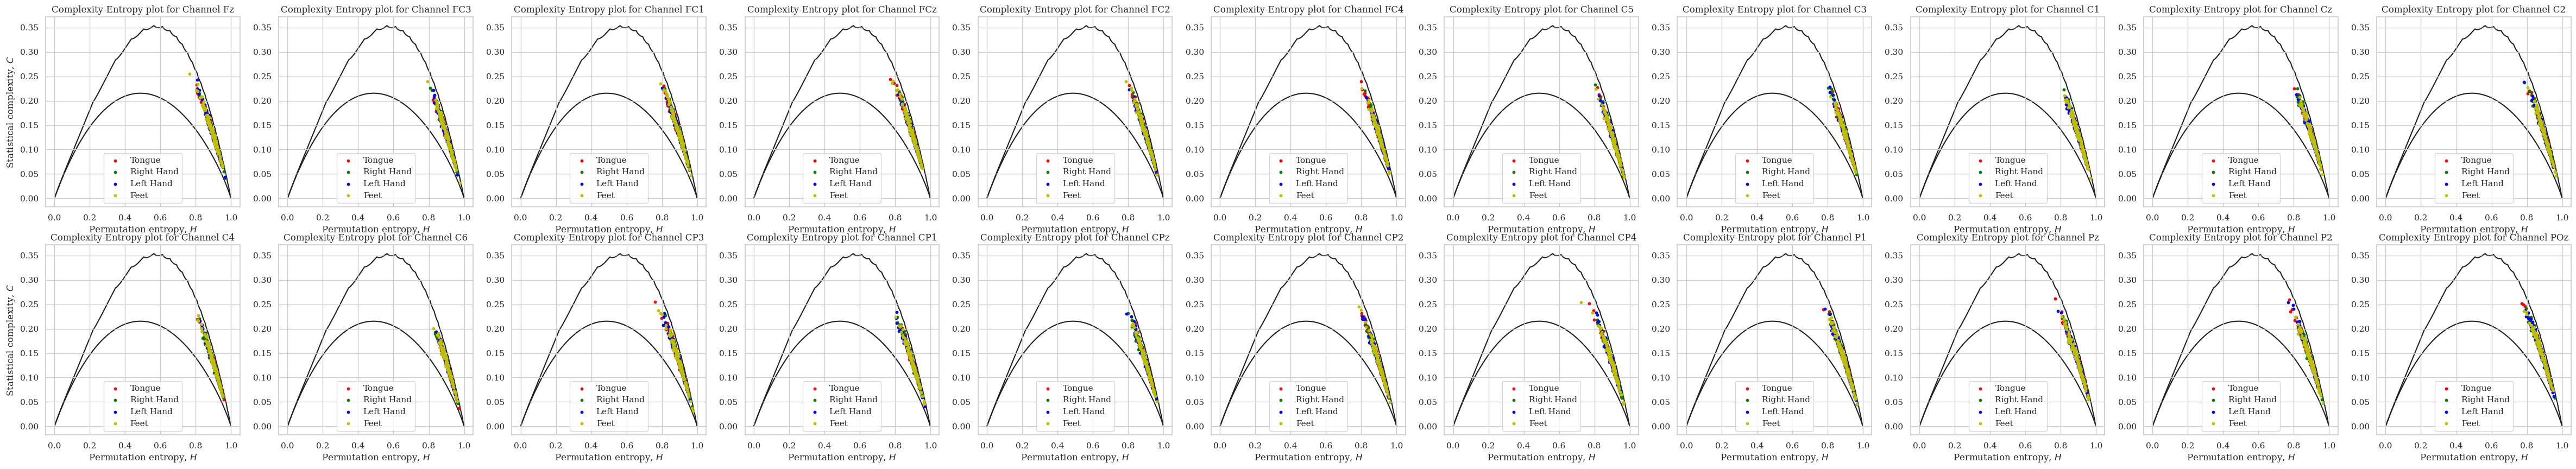

In [23]:
f, ax = plt.subplots(2, 11, figsize=(60, 10))
ax[0, 0].set_ylabel('Statistical complexity, $C$')
ax[1, 0].set_ylabel('Statistical complexity, $C$')
for channel in range(X.shape[1]):
	result = generate_complexity_entropy_values_channel(X, y_encoded, channel)
	tongue = result[result[:, 2] == 0]
	right_hand = result[result[:, 2] == 1]
	left_hand = result[result[:, 2] == 2]
	feet = result[result[:, 2] == 3]

	row_idx = channel // 11
	col_idx = channel % 11

	upper = ax[row_idx, col_idx].plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)
	lower = ax[row_idx, col_idx].plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)
	tongue_points = ax[row_idx, col_idx].scatter(x=tongue[:,0], y=tongue[:,1], c="r", s=10)
	right_hand_points = ax[row_idx, col_idx].scatter(x=right_hand[:,0], y=right_hand[:,1], c="g", s=10)
	left_hand_points = ax[row_idx, col_idx].scatter(x=left_hand[:,0], y=left_hand[:,1], c="b", s=10)
	feet_points = ax[row_idx, col_idx].scatter(x=feet[:,0], y=feet[:,1], c="y", s=10)
	ax[row_idx, col_idx].set_xlabel('Permutation entropy, $H$')
	ax[row_idx, col_idx].set_title(f"Complexity-Entropy plot for Channel {ch_names[channel]}")
	ax[row_idx, col_idx].grid(visible=True)
	ax[row_idx, col_idx].legend((upper, lower, tongue_points, right_hand_points, left_hand_points, feet_points), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Tongue", "Right Hand", "Left Hand", "Feet"), scatterpoints=1)
plt.show()

In [18]:
def generate_complexity_entropy_values_trial(X, trial_idx):
	assert X.shape[0] == y_encoded.shape[0]
	entropy_complexities = np.zeros((X.shape[1], 2)) # entropy, complexity
	for channel in range(X.shape[1]):
		entropy, complexity = ordpy.complexity_entropy(data=X[trial_idx, channel, :250], dx=int(5), dy=int(1), taux=int(3), tauy=int(1))
		entropy_complexities[channel][0] = entropy
		entropy_complexities[channel][1] = complexity
	return entropy_complexities
trial = 0
result_trial = generate_complexity_entropy_values_trial(X, trial)
print(result_trial.shape)

(22, 2)


In [19]:
trials = []
for trial_idx in tqdm(range(X.shape[0])):
	trial_hc = generate_complexity_entropy_values_trial(X, trial_idx)
	trials.append(trial_hc)

100%|██████████| 576/576 [01:11<00:00,  8.06it/s]


In [20]:
all_trials = np.concatenate(trials, axis=0)
print(all_trials.shape)

(12672, 2)


/tmp/ipykernel_157864/2972197891.py:10: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend((upper, lower, points), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Data"), scatterpoints=1)


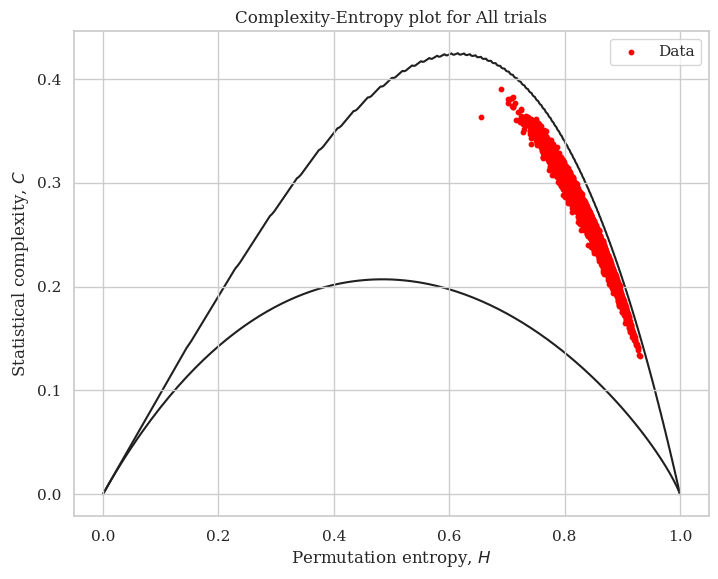

In [21]:
f, ax = plt.subplots(figsize=(8.19, 6.3))

upper = ax.plot(hmin, cmin, linewidth=1.5, color='#202020', zorder=0)
lower = ax.plot(hmax, cmax, linewidth=1.5, color='#202020', zorder=0)
points = ax.scatter(x=all_trials[:,0], y=all_trials[:,1], c="r", s=10)
ax.set_xlabel('Permutation entropy, $H$')
ax.set_ylabel('Statistical complexity, $C$')
ax.set_title(f"Complexity-Entropy plot for All trials")
ax.grid(visible=True)
ax.legend((upper, lower, points), ("Maximum Complexity Entropy", "Minimum Complexity Entropy", "Data"), scatterpoints=1)